## Basic Setup

In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from matplotlib import pyplot as plt

mp.quiet(quietval=True)
seed = 24
np.random.seed(seed)

resolution = 10

Sx = 6
Sy = 5
cell_size = mp.Vector3(Sx,Sy)

pml_layers = [mp.PML(1.0)]

fcen = 1/1.55
width = 0.2
fwidth = width * fcen
source_center  = [-1,0,0]
source_size    = mp.Vector3(0,2,0)
kpoint = mp.Vector3(1,0,0)
src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)

source = [mp.Source(src,component=mp.Ez,
                    size = source_size,
                    center=source_center)]


design_region_resolution = 10

design_region = mp.Volume(center=mp.Vector3(), size=mp.Vector3(1, 1, 0))
design_variables = mpa.BilinearInterpolationBasis(volume=design_region,resolution=design_region_resolution)

geometry = [
    mp.Block(center=mp.Vector3(x=-Sx/4), material=mp.Medium(index=3.45), size=mp.Vector3(Sx/2, 0.5, 0)), # horizontal waveguide
    mp.Block(center=mp.Vector3(y=Sy/4), material=mp.Medium(index=3.45), size=mp.Vector3(0.5, Sy/2, 0)),  # vertical waveguide
    mp.Block(center=design_region.center, size=design_region.size, epsilon_func=design_variables.func()) # design region
]


sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    eps_averaging=False,
                    resolution=resolution)


Ez0 = mpa.Ez_Coefficients(sim,mp.Volume(center=mp.Vector3(0,1,0),size=mp.Vector3(2,0,0)))
ob_list = [Ez0]






## Objective Functions

In [2]:
def J1(alpha):
    return npa.abs(alpha[0,0]) **2


def J2(alpha):
    return npa.abs(alpha[0,0]) **2 + npa.abs(alpha[0,1]) **2 + npa.abs(alpha[0,2]) **2 + npa.abs(alpha[0,3]) **2 +\
    npa.abs(alpha[0,4]) **2 + npa.abs(alpha[0,5]) **2 + npa.abs(alpha[0,6]) **2 + npa.abs(alpha[0,7]) **2 + npa.abs(alpha[0,8]) **2 + npa.abs(alpha[0,9]) **2 +\
    npa.abs(alpha[0,10]) **2 + npa.abs(alpha[0,11]) **2 + npa.abs(alpha[0,12]) **2 + npa.abs(alpha[0,13]) **2 + npa.abs(alpha[0,14]) **2 + npa.abs(alpha[0,15]) **2 +\
    npa.abs(alpha[0,16]) **2 + npa.abs(alpha[0,17]) **2 +npa.abs(alpha[0,18]) **2 + npa.abs(alpha[0,19]) **2 + npa.abs(alpha[0,20]) **2 + npa.abs(alpha[0,21]) **2

def J3(alpha):
    return npa.sum(npa.abs(alpha[0,:])**2)

def J4(alpha):
    sum_sq = 0
    for i in alpha[0,:]:
        sum_sq += npa.abs(i)**2
    return sum_sq

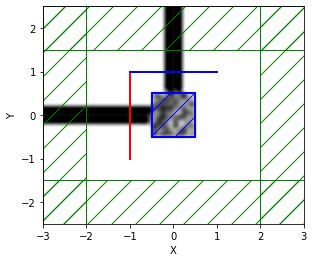

In [3]:
opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=J1,
    objective_arguments=ob_list,
    design_variables=[design_variables],
    fcen=fcen,
    df = 0,
    nf = 1,
    decay_fields=[mp.Ez]
)


Nx = design_variables.Nx # number of parameters in the x direction
Ny = design_variables.Ny # number of parameters in the y direction
x0 = 11*np.random.rand(Nx*Ny) + 1
opt.update_design([x0])


opt.plot2D(True)
plt.show()



## Test Runs

When optimizing the coefficient at a point, the adjoint gradient is off by a constant compared to the FD gradient.

Starting forward run...
Starting adjoint run...
Calculating gradient...


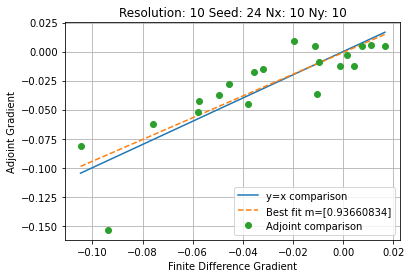

Starting forward run...
Starting adjoint run...
Calculating gradient...


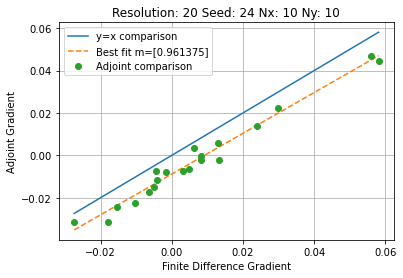

Starting forward run...
Starting adjoint run...
Calculating gradient...


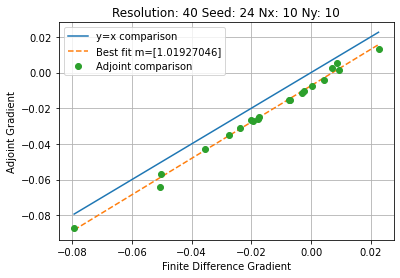

In [4]:
db = 1e-3
choose = 20
for resolution in [10, 20, 40]:
    np.random.seed(seed)
    opt.sim.resolution = resolution
    f0, dJ_deps, dg = opt()
    g_adjoint = design_variables.get_basis_vjp(dJ_deps,dg)
    g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose,db=db)


    (m, b) = np.polyfit(np.squeeze(g_discrete), g_adjoint[idx], 1)
    min_g = np.min(g_discrete)
    max_g = np.max(g_discrete)

    plt.figure()
    plt.plot([min_g, max_g],[min_g, max_g],label='y=x comparison')
    plt.plot([min_g, max_g],[m*min_g+b, m*max_g+b],'--',label='Best fit m='+str(m))
    plt.plot(g_discrete,g_adjoint[idx],'o',label='Adjoint comparison')
    plt.xlabel('Finite Difference Gradient')
    plt.ylabel('Adjoint Gradient')
    plt.title('Resolution: {} Seed: {} Nx: {} Ny: {}'.format(resolution,seed,Nx,Ny))
    plt.legend()
    plt.grid(True)
    plt.show()

It works when optimizing over more points. Higher resolution is needed for convergence.

Starting forward run...
Starting adjoint run...
Calculating gradient...


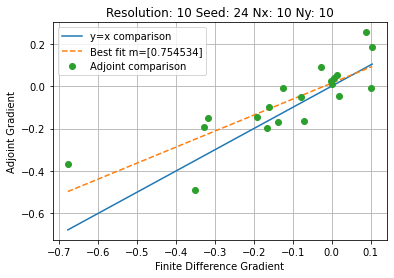

Starting forward run...
Starting adjoint run...
Calculating gradient...


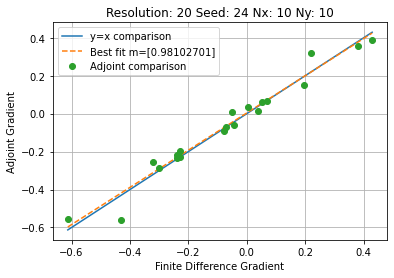

Starting forward run...
Starting adjoint run...
Calculating gradient...


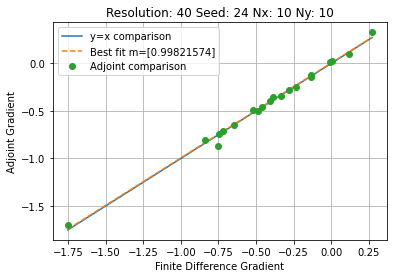

In [5]:
opt.objective_functions = [J2]
for resolution in [10, 20, 40]:
    np.random.seed(seed)
    opt.sim.resolution = resolution
    f0, dJ_deps, dg = opt()
    g_adjoint = design_variables.get_basis_vjp(dJ_deps,dg)
    g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose,db=db)


    (m, b) = np.polyfit(np.squeeze(g_discrete), g_adjoint[idx], 1)
    min_g = np.min(g_discrete)
    max_g = np.max(g_discrete)

    plt.figure()
    plt.plot([min_g, max_g],[min_g, max_g],label='y=x comparison')
    plt.plot([min_g, max_g],[m*min_g+b, m*max_g+b],'--',label='Best fit m='+str(m))
    plt.plot(g_discrete,g_adjoint[idx],'o',label='Adjoint comparison')
    plt.xlabel('Finite Difference Gradient')
    plt.ylabel('Adjoint Gradient')
    plt.title('Resolution: {} Seed: {} Nx: {} Ny: {}'.format(resolution,seed,Nx,Ny))
    plt.legend()
    plt.grid(True)
    plt.show()

Starting forward run...
Starting adjoint run...
Calculating gradient...


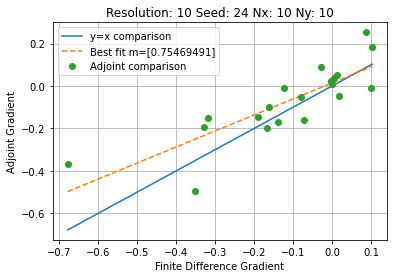

Starting forward run...
Starting adjoint run...
Calculating gradient...


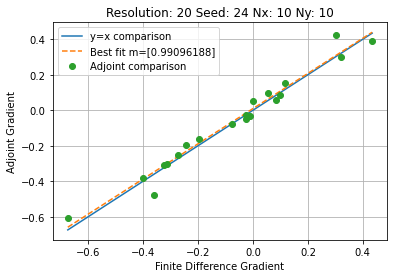

Starting forward run...
Starting adjoint run...
Calculating gradient...


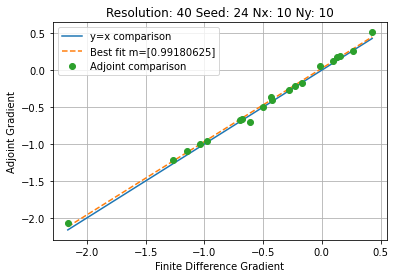

In [6]:
opt.objective_functions = [J4]
for resolution in [10, 20, 40]:
    np.random.seed(seed)
    opt.sim.resolution = resolution
    f0, dJ_deps, dg = opt()
    g_adjoint = design_variables.get_basis_vjp(dJ_deps,dg)
    g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose,db=db)


    (m, b) = np.polyfit(np.squeeze(g_discrete), g_adjoint[idx], 1)
    min_g = np.min(g_discrete)
    max_g = np.max(g_discrete)

    plt.figure()
    plt.plot([min_g, max_g],[min_g, max_g],label='y=x comparison')
    plt.plot([min_g, max_g],[m*min_g+b, m*max_g+b],'--',label='Best fit m='+str(m))
    plt.plot(g_discrete,g_adjoint[idx],'o',label='Adjoint comparison')
    plt.xlabel('Finite Difference Gradient')
    plt.ylabel('Adjoint Gradient')
    plt.title('Resolution: {} Seed: {} Nx: {} Ny: {}'.format(resolution,seed,Nx,Ny))
    plt.legend()
    plt.grid(True)
    plt.show()

Apparently, J3 works in the notebook; but in terminal, adjoint gradient can blow up from time to time.

Starting forward run...
Starting adjoint run...
Calculating gradient...


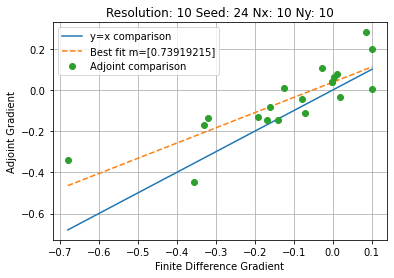

In [12]:
np.random.seed(seed)
opt.objective_functions = [J3]
resolution = 10   
opt.sim.resolution = resolution   
f0, dJ_deps, dg = opt()
g_adjoint = design_variables.get_basis_vjp(dJ_deps,dg)
g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose,db=db)

(m, b) = np.polyfit(np.squeeze(g_discrete), g_adjoint[idx], 1)
min_g = np.min(g_discrete)
max_g = np.max(g_discrete)

plt.figure()
plt.plot([min_g, max_g],[min_g, max_g],label='y=x comparison')
plt.plot([min_g, max_g],[m*min_g+b, m*max_g+b],'--',label='Best fit m='+str(m))
plt.plot(g_discrete,g_adjoint[idx],'o',label='Adjoint comparison')
plt.xlabel('Finite Difference Gradient')
plt.ylabel('Adjoint Gradient')
plt.title('Resolution: {} Seed: {} Nx: {} Ny: {}'.format(resolution,seed,Nx,Ny))
plt.legend()
plt.grid(True)
plt.show()

Increasing resolution doesn't solve the issue with J1. My guess is that we should use Yee grid.

Starting forward run...
Starting adjoint run...
Calculating gradient...


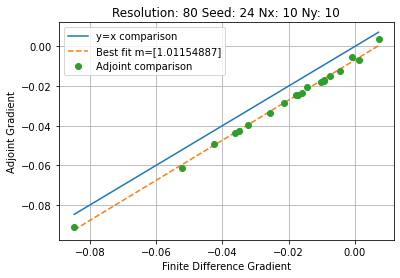

In [13]:
np.random.seed(seed)
opt.objective_functions = [J1]
resolution = 80   
opt.sim.resolution = resolution   
f0, dJ_deps, dg = opt()
g_adjoint = design_variables.get_basis_vjp(dJ_deps,dg)
g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose,db=db)

(m, b) = np.polyfit(np.squeeze(g_discrete), g_adjoint[idx], 1)
min_g = np.min(g_discrete)
max_g = np.max(g_discrete)

plt.figure()
plt.plot([min_g, max_g],[min_g, max_g],label='y=x comparison')
plt.plot([min_g, max_g],[m*min_g+b, m*max_g+b],'--',label='Best fit m='+str(m))
plt.plot(g_discrete,g_adjoint[idx],'o',label='Adjoint comparison')
plt.xlabel('Finite Difference Gradient')
plt.ylabel('Adjoint Gradient')
plt.title('Resolution: {} Seed: {} Nx: {} Ny: {}'.format(resolution,seed,Nx,Ny))
plt.legend()
plt.grid(True)
plt.show()